(lecture_19)=
# Generalized Linear Madness
:::{post} Jan 7, 2024
:tags: statistical rethinking, bayesian inference, generalized linear models
:category: intermediate
:author: Dustin Stansbury
:::

This notebook is part of the PyMC port of the [Statistical Rethinking 2023](https://github.com/rmcelreath/stat_rethinking_2023) lecture series by Richard McElreath.

[Video - Lecture 19 - Generalized Linear Madness](https://youtu.be/zffwg0xDOgE)# [Lecture 19 - Generalized Linear Madness](https://www.youtube.com/watch?v=zffwg0xDOgE)

In [1]:
# Ignore warnings
import warnings

import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
import statsmodels.formula.api as smf
import utils as utils
import xarray as xr

from matplotlib import pyplot as plt
from matplotlib import style
from scipy import stats as stats

warnings.filterwarnings("ignore")

# Set matplotlib style
STYLE = "statistical-rethinking-2023.mplstyle"
style.use(STYLE)

# GLMs & GLMM & Generalized Linear Habits

- Flexible association engines, not mechanistic scientific models of mechanisms that generate phenomena
  - May leave information on the table
  - May be less efficient
  - Mechanistic causal models often more interpretable
- Rather they are information-theoretic devices
- Even still, >90% of scientific work is done using GLM/GLMMs

**Alternative Approach - Start with simple sceintific principles, and build in estimation**

## Revisiting Modeling Human Height ⚖️

- Weight of human is proportional to the **volume** of the human
  - Taller humans have more volume that shorter humans
  - Thus taller humans weight more (I know this is super-basic, that's the point)
- Thus the weight of a human falls back on simple physics: **the shape of a human determines their mass, and thus their weight**
- We can model the **shape** of a human in lots, of ways, but the simplest (albeit cartoonish) is probabily as a cylindar.
  - rare that people are wider than they are tall -- we can model radius of cylindar as proportion of height
  - push statistical estimation as far down the analysis pipeline as possible

### Cartoonish Scientific model

- Captures the causal relationships between height and weight
- Causal because, it tells us how changing height will effect weight

$$
\begin{align*}
V &= \pi r^2 h &\text{Volume of cylindar} \\
V &= \pi (ph)^2 h &\text{radius as proportion of height, } p \\
W &= kV = k\pi (ph)^2 h &\text{converting volume to weight} \\
W &= k\pi p^2 h^3 \\
\end{align*}
$$

- $W$ weight (observed data, a' la' Howell dataset)
- $h$ heith (observed data)
- $k$ density (parameter to estimate)
- $p$ proportion of height (parameter to estimate)

### Statistical Model

#### General conversion of the scientific model to statistical model

$$
\begin{align*}
W_i &\sim \text{Likelihood}(\mu_i) &\text{"error" distribution for } W\\
\mu_i &= k\pi (ph)^2 H_i &\text{expected value of } W_i | H_i \\
p &\sim \text{Prior}(...)  &\text{distribution for proportionality} \\
k &\sim \text{Prior}(...)  &\text{distribution for density} \\
\end{align*}
$$


#### Priors

Now that parameters $p,k$ have real-world interpretations, determining priors for them is now more straight-forward than for a typical GLM/GLMM

**Prior Development Workflow**
1. Choose measurement scale (or removing them)
2. Simulate
3. Think

**1. Measuremnt Scales**
- $\mu$ - $kg$
- $H$ - $cm^3$
- $k$ - $kg/cm^3$


- You can always rescale a measurement scale using a reference
  - e.g. dividing out mean weight and height
- Try dividing out measuremnt units when possible
- Often easier to deal with dimensionless quantities


In [2]:
HOWELL = utils.load_data("Howell1")

# Add rescaled data
HOWELL.loc[:, "height_scaled"] = HOWELL.height / HOWELL.height.mean()
HOWELL.loc[:, "weight_scaled"] = HOWELL.weight / HOWELL.weight.mean()
HOWELL

,height,weight,age,male,height_scaled,weight_scaled
0,151.765,47.825606,63.0,1,1.097650,1.343015
1,139.700,36.485807,63.0,0,1.010389,1.024577
2,136.525,31.864838,65.0,0,0.987425,0.894813
3,156.845,53.041914,41.0,1,1.134391,1.489497
4,145.415,41.276872,51.0,0,1.051723,1.159117
...,...,...,...,...,...,...
539,145.415,31.127751,17.0,1,1.051723,0.874114
540,162.560,52.163080,31.0,1,1.175725,1.464818
541,156.210,54.062497,21.0,0,1.129798,1.518157
542,71.120,8.051258,0.0,1,0.514380,0.226092


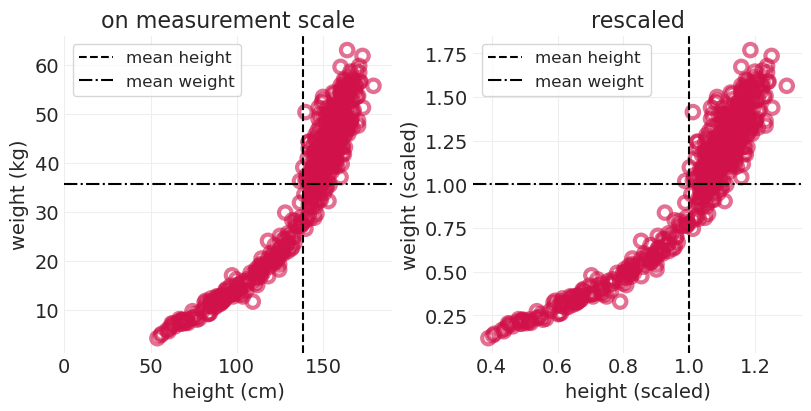

In [3]:
_, axs = plt.subplots(1, 2, figsize=(8, 4))

plt.sca(axs[0])
utils.plot_scatter(HOWELL.height, HOWELL.weight)
plt.axvline(HOWELL.height.mean(), color="k", linestyle="--", label="mean height")
plt.axhline(HOWELL.weight.mean(), color="k", linestyle="-.", label="mean weight")
plt.xlim([0, 190])
plt.xlabel("height (cm)")
plt.ylabel("weight (kg)")
plt.legend()
plt.title("on measurement scale")

plt.sca(axs[1])
utils.plot_scatter(HOWELL.height_scaled, HOWELL.weight_scaled)
plt.axvline(HOWELL.height_scaled.mean(), color="k", linestyle="--", label="mean height")
plt.axhline(HOWELL.weight_scaled.mean(), color="k", linestyle="-.", label="mean weight")
plt.xlabel("height (scaled)")
plt.ylabel("weight (scaled)")
plt.legend()
plt.title("rescaled");

**2. Simulate**

$$
\begin{align*}
p &\sim \text{Prior}_p(...)  &\in (0, 1), \lt 0.5 \\
k &\sim \text{Prior}_k(...)  &\text{postitive real, }\gt 1.0 \\
\end{align*}
$$

- **proportion, $p$**
  - by definition of a proportion $\in (0, 1)$
  - has to be $\lt 0.5$ because humans are generally not wider than they are tall


- **density, $k$**

  - density has to be $\gt 1$ because there is a positive relationships between height and weight

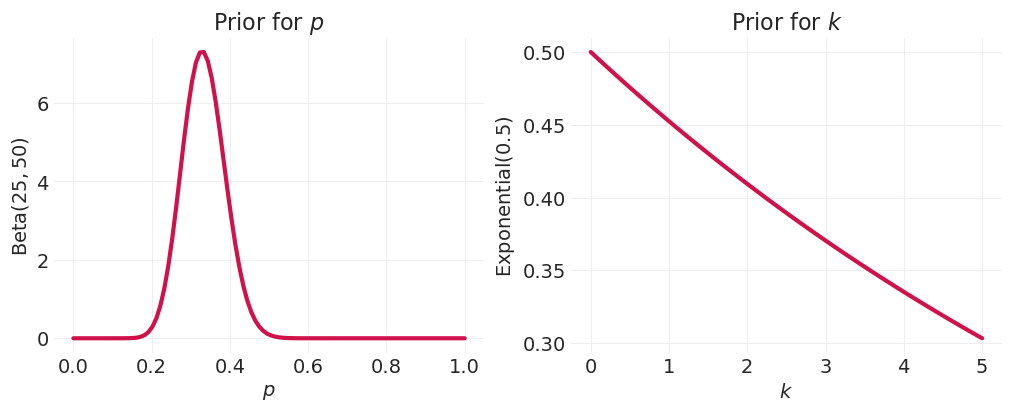

In [4]:
p_prior = stats.beta(a=25, b=50)
ps = np.linspace(0, 1, 100)

rate = 0.5
k_prior = stats.expon(scale=1 / rate)
ks = np.linspace(0, 5, 100)


_, axs = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axs[0])
utils.plot_line(ps, p_prior.pdf(ps), label=None)
plt.xlabel("$p$")
plt.ylabel("Beta$(25, 50)$")
plt.title("Prior for $p$")


plt.sca(axs[1])
utils.plot_line(ks, k_prior.pdf(ps), label=None)
plt.xlabel("$k$")
plt.ylabel("Exponential$(0.5)$")
plt.title("Prior for $k$");

#### Prior predictive simulation

$$
\begin{align*}
W &\sim \text{LogNormal}(\mu_i, \sigma) & \in \mathbb{R} \text{, variance scales with mean} \\
\exp(\mu_i) &= k\pi p^2 H_i^3   & \text{growth is multiplicative, LogNormal is natural choice} \\
p &\sim \text{Beta}(25, 50) \\
k &\sim \text{Exponential}(0.5) \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

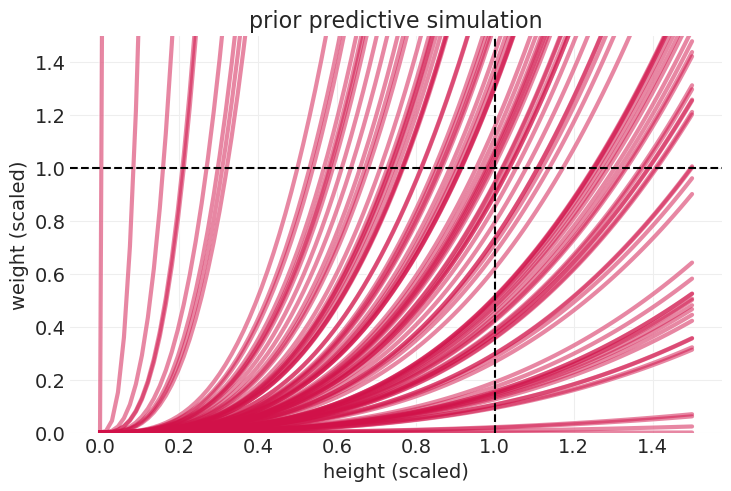

In [5]:
np.random.seed(123)
n_prior_samples = 100
p_samples = p_prior.rvs(size=n_prior_samples)
k_samples = k_prior.rvs(size=n_prior_samples)
sigma_samples = stats.expon(scale=1).rvs(n_prior_samples)

heights = np.linspace(0, 1.5, 100)[:, None]

# Log-normally-distributed weight
prior_mus = np.log(np.pi * k_samples * p_samples**2 * heights**3)

# expected value on natural scale
prior_lines = np.exp(prior_mus + sigma_samples**2 / 2)

utils.plot_line(heights, prior_lines, label=None, color="C0", alpha=0.5)
plt.axvline(1, color="k", linestyle="--", zorder=100)
plt.axhline(1, color="k", linestyle="--", zorder=100)
plt.ylim([0, 1.5])
plt.xlabel("height (scaled)")
plt.ylabel("weight (scaled)")
plt.title("prior predictive simulation");

#### Fit the statistical model

In [6]:
with pm.Model() as cylinder_model:
    H = pm.MutableData("H", HOWELL.height_scaled, dims="obs_id")
    W = HOWELL.weight_scaled
    PI = 3.141593

    sigma = pm.Exponential("sigma", 1)
    p = pm.Beta("p", 25, 50)
    k = pm.Exponential("k", 0.5)

    mu = pm.math.log(PI * k * p**2 * H**3)
    pm.LogNormal("W", mu, sigma, observed=W, dims="obs_id")
    cylinder_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p, k]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [7]:
def plot_cylinder_model_posterior(model, inference, title=None):
    heights = np.linspace(0, 1.3, 100)
    with model:
        pm.set_data({"H": heights})
        ppd = pm.sample_posterior_predictive(
            inference,
            return_inferencedata=True,
            predictions=True,
            extend_inferencedata=False,
        )
    az.plot_hdi(heights, ppd.predictions["W"], color="C0")
    utils.plot_line(
        heights, ppd.predictions["W"].mean(dim=("chain", "draw")), color="k", label="posterior"
    )
    utils.plot_scatter(HOWELL.height_scaled, HOWELL.weight_scaled, color="C0")
    plt.xlabel("height (scaled)")
    plt.ylabel("weight (scaled)")
    plt.legend()
    plt.title(title)

Sampling: [W]


Output()

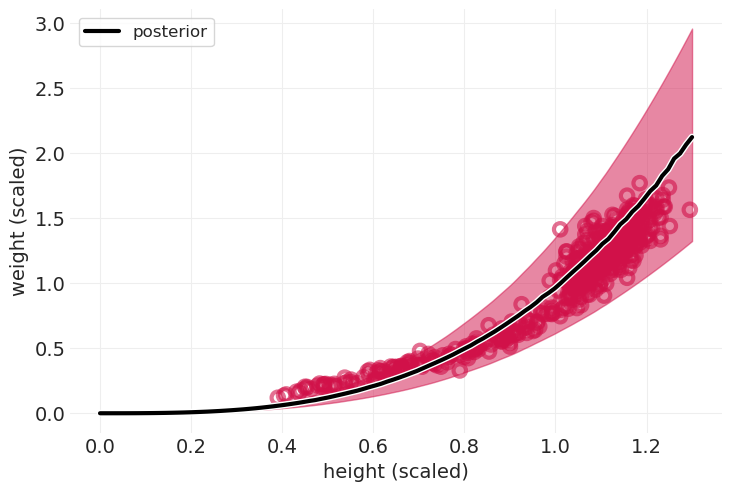

In [8]:
plot_cylinder_model_posterior(cylinder_model, cylinder_inference);

### Insightful errors
- not bad for a cylindar
- poor fit for children
- in scientific model, errors are informative
  - likely $p$ is different for children

**3. Think**

Bayesian inference has discovered that $k$ and $p$ are functionally related

You can derive the same relationship using algebra, and the notion that the average human has a hieght of 1

$$
\begin{align*}
\mu &= k \pi p^2 H^3 \\
(1) &= k \pi p^2 (1)^3 \\
1 &= k \pi p^2 \\
k &=  \frac{1}{\pi p^2} \\
\end{align*}
$$

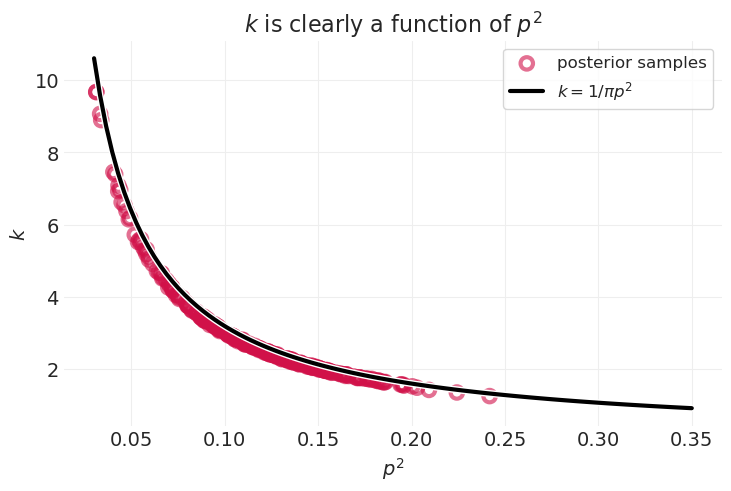

In [9]:
n_posterior_samples = 300
utils.plot_scatter(
    cylinder_inference.posterior["p"][0, :n_posterior_samples] ** 2,
    cylinder_inference.posterior["k"][0, :n_posterior_samples],
    label="posterior samples",
)
p_squared = np.linspace(0.03, 0.35, 100)
k_analytic = 1 / (np.pi * p_squared)

utils.plot_line(p_squared, k_analytic, color="k", label=r"$k=1/\pi p^2$")
plt.legend()
plt.xlabel("$p^2$")
plt.ylabel("$k$")
plt.title("$k$ is clearly a function of $p^2$");

It turns out that we dont' even need the parameters $k, p$. If we can take the product all parameters in the model to give a single parameter $\theta=kp^2$, we can solve the above equation using the same average person trick

$$
\begin{align*}
\mu &= k \pi p^2 H^3 \\
(1) &= \pi \theta (1)^3 \\
1 &= \pi \theta \\
\theta &= \frac{1}{\pi} \\
\end{align*}
$$

Thus the parameter $\theta = k p^2$ is just a constant, $1/\pi$, so **there are no parameters to estimate** 🤯

### Fit the dimensionless cylindar model

$$
\begin{align*}
W &\sim \text{LogNormal}(\mu_i, \sigma) & \in \mathbb{R} \text{, variance scales with mean} \\
\exp(\mu_i) &= H_i^3   & \text{growth is multiplicative, LogNormal is natural choice} \\
\sigma &\sim \text{Exponential}(1)
\end{align*}
$$

In [10]:
with pm.Model() as dimensionless_cylinder_model:
    H = pm.MutableData("H", HOWELL.height_scaled, dims="obs_id")
    W = HOWELL.weight_scaled

    sigma = pm.Exponential("sigma", 1)

    mu = pm.math.log(H**3)
    pm.LogNormal("W", mu, sigma, observed=W, dims="obs_id")
    dimensionless_cylinder_inference = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


Sampling: [W]


Output()

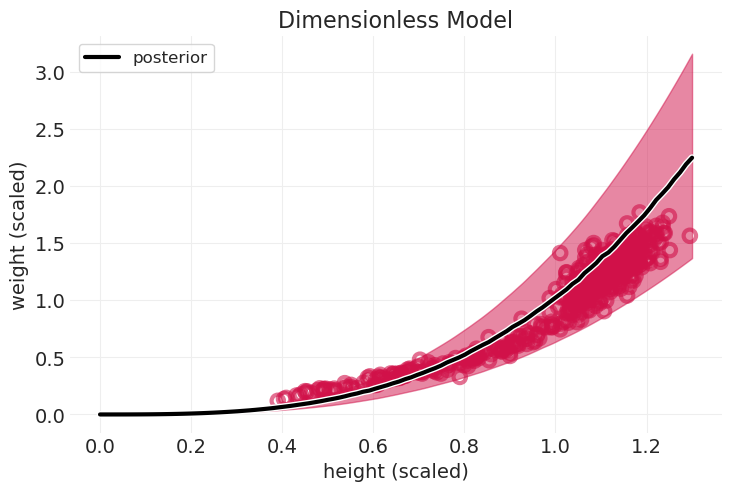

In [11]:
plot_cylinder_model_posterior(
    dimensionless_cylinder_model, dimensionless_cylinder_inference, title="Dimensionless Model"
);

Sampling: [W]


Output()

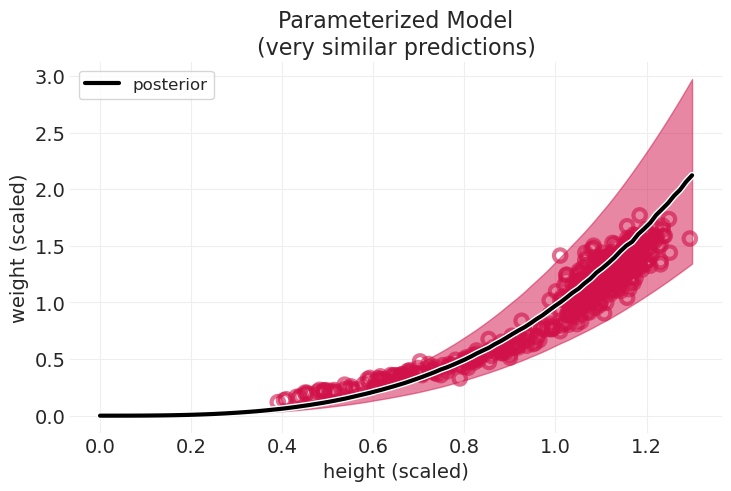

In [12]:
plot_cylinder_model_posterior(
    cylinder_model, cylinder_inference, title="Parameterized Model\n(very similar predictions)"
);

## Review: Geometric People

- Most of $H \rightarrow W$ is de to the relationship between length and volume
- Changes in body shape explain in a poor fit for children -- this is where a proportionality $p$ that varies with age may help improve the model
- Postponing thinking statistically long as possible often leads to a better statistical model
- No empricisism without thinking about what you're actually measuring

# Choices, observation, and learning strategies 🟦🟥

## Experiment 

- <span style="color:red">Majority choice</span>
  - Three different children choose 🟥 and get a prize
- <span style="color:#E6C229">Minority choice</span>
  - Once child chooses 🟨 three times, and gets three prizes
- <span style="color:blue">Uchosen<span>
  - 🟦 is not chosen by any children
- Total evidence for chosen colors is the 🟥,🟥,🟥,🟨,🟨,🟨

### Social Conformity
- **What strategy do other children take when choosing a color, after witnessing the above data?**
- Do chidren copy the <span style="color:red">majority choice</span> -- i.e. the majority **strategy**?
- Problem: cannot directly observe the strategy, only the choice
  - The majority choice is consistent with many strategies
  - Choosing a color randomly $\rightarrow 1/3$
  - Random demonstrator $\rightarrow 3/4$
  - Random demonstration $\rightarrow 1/2$

### Think scientifically, simulate data

In [13]:
np.random.seed(123)
N_SIMULATED_CHILDREN = 100

# half of children take the random color strategy
y_random = np.random.choice([1, 2, 3], N_SIMULATED_CHILDREN // 2, replace=True)

# the other half follow the majority -> p(majority) = 0.5
y_majority = np.random.choice([2], N_SIMULATED_CHILDREN // 2, replace=True)

perm_idx = np.random.permutation(np.arange(N_SIMULATED_CHILDREN))
y_simulated = np.concatenate([y_random, y_majority])[perm_idx]

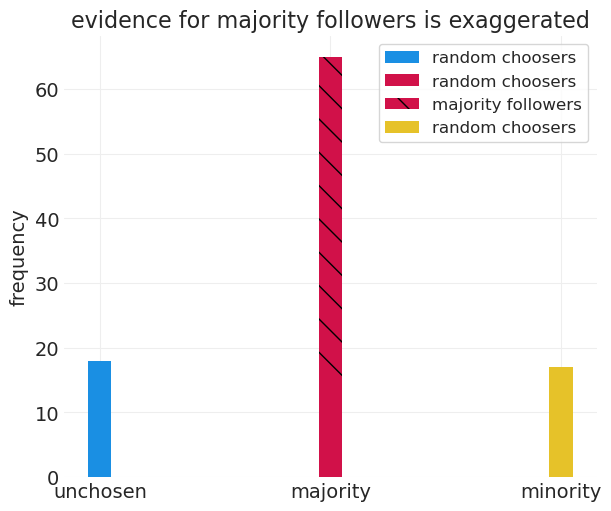

In [14]:
plt.subplots(figsize=(6, 5))
counts, _ = np.histogram(y_random, bins=3)
strategy_labels = ["unchosen", "majority", "minority"]
strategy_colors = ["C1", "C0", "C3"]
for ii, (cnt, l, c) in enumerate(zip(counts, strategy_labels, strategy_colors)):
    plt.bar(ii, cnt, color=c, width=0.1, label="random choosers")
    if ii == 1:
        plt.bar(
            1,
            len(y_majority),
            bottom=cnt,
            color=c,
            width=0.1,
            label="majority followers",
            hatch="\\",
        )
plt.legend()
plt.xticks([0, 1, 2], labels=strategy_labels)
plt.ylabel("frequency")
plt.title("evidence for majority followers is exaggerated");

## State-based Model

- Majority choice does not indicate majority preference, as there are multiple strategies that could lead to that choice
- Instead infer the unobserved strategy from a space of potential strateiges

### Strategy space

1. <span style="color:red">Majority choice</span> : choose the color chosen by the majority demonstrators
2. <span style="color:#E6C229">Minority choice</span>: choose the color chosen by the minority demonstrator
3. <span style="color:blue">Maveric</span> : choose the color not chosen
4. <span style="color:green">Random Color</span> : choose a color at random
   - this says we don't know what causes the color choice, but that strategy isn't conditioned on the behavior of demonstrators
   - e.g. could be the chooser's favorite color
6. <span style="color:purple">Follow First</span> : choose a color picked by the first child (could imagine havin a "Follow Last" analog
   - primacy effect
  
### State-based statistical Model

$$
\begin{align*}
Y_i &= \text{Categorical}(\theta) & \theta \text{ is vector of probabilities, one for each choice} \\
\theta_j &= \sum_{S=1}^5 p_S P(Y=j | S) \\
p &\sim \text{Dirichlet}([4,4,4,4,4])  &\text{ all strategies are equally likely a priori} \\
\end{align*}
$$

In [15]:
def strategy_logp(y, p, majority_first):
    """
    y: observation
    p: prior
    majority_first: whether the majority choice was shown first before this decision was made
    """
    SWITCH = pm.math.switch
    EQ = pm.math.eq
    N_STRATEGIES = 5

    # reset params
    theta = [0] * N_STRATEGIES
    # p(data)
    theta[0] = SWITCH(EQ(y, 2), 1, 0)  # majority
    theta[1] = SWITCH(EQ(y, 3), 1, 0)  # minority
    theta[2] = SWITCH(EQ(y, 1), 1, 0)  # maverick
    theta[3] = pm.math.ones_like(y) * 1.0 / 3.0  # random color
    theta[4] = SWITCH(  # follow-first
        EQ(majority_first, 1), SWITCH(EQ(y, 2), 1, 0), SWITCH(EQ(y, 3), 1, 0)
    )

    # log probability -> log(p_S * P(y_i | S))
    for si in range(N_STRATEGIES):
        theta[si] = pm.math.log(p[si]) + pm.math.log(theta[si])

    return pm.math.logsumexp(theta, axis=0)


STRATEGY = ["majority", "minority", "maverick", "random color", "follow first"]


def fit_child_strategy_model(data):

    Y = data.y.values.astype(int)
    MAJORITY_FIRST = data.majority_first.values.astype(int)

    with pm.Model(coords={"strategy": STRATEGY}) as child_strategy_model:
        # Prior
        p = pm.Dirichlet("p", np.array([4, 4, 4, 4, 4]), dims="strategy")

        # Likelihood
        pm.CustomDist("Y", p, MAJORITY_FIRST, logp=strategy_logp, observed=Y)
        child_strategy_inference = pm.sample()

    return child_strategy_model, child_strategy_inference

### Fit the strategy model to simulated data

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


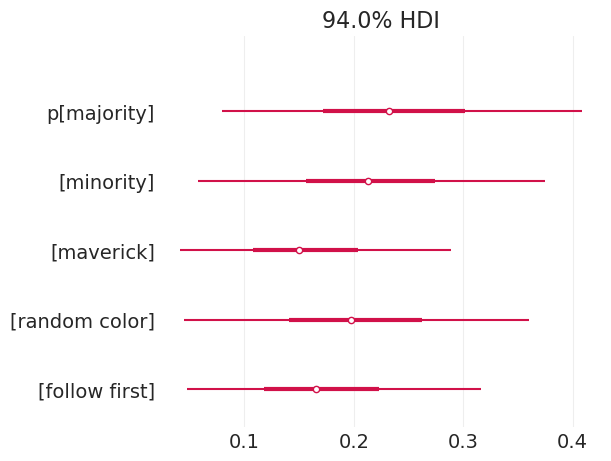

In [16]:
BOXES_SIMULATED = pd.DataFrame(
    {
        "y": y_simulated,
        "majority_first": stats.bernoulli(p=0.5).rvs(
            size=N_SIMULATED_CHILDREN
        ),  # decouple first choice from strategy, "follow first" strategy should be near zero
    }
)
child_strategy_model_simulated, child_strategy_inference_simulated = fit_child_strategy_model(
    BOXES_SIMULATED[:5]
)
pm.plot_forest(child_strategy_inference_simulated, var_names=["p"], combined=True);

We can see that we're able to recover the simulated probability of the majority strategy, which was 0.5.

### Fit the strategy model to real data

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


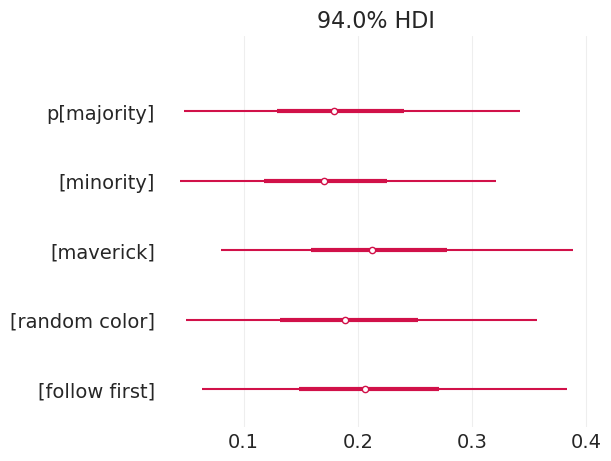

In [17]:
BOXES = utils.load_data("Boxes")

child_strategy_model, child_strategy_inference = fit_child_strategy_model(BOXES[:5])

pm.plot_forest(child_strategy_inference, var_names=["p"], combined=True);

- good amount of evidene for majority strategy
- good amount of evidence for follow first strategy
- random color has large variance
  - haunts the experiment, as random choice can always explain away evidence of the others
  - we can verify this by looking at the correlation of the $p$'s for each strategy: the 'random color' strategy is anti-correlated with all the other strategies

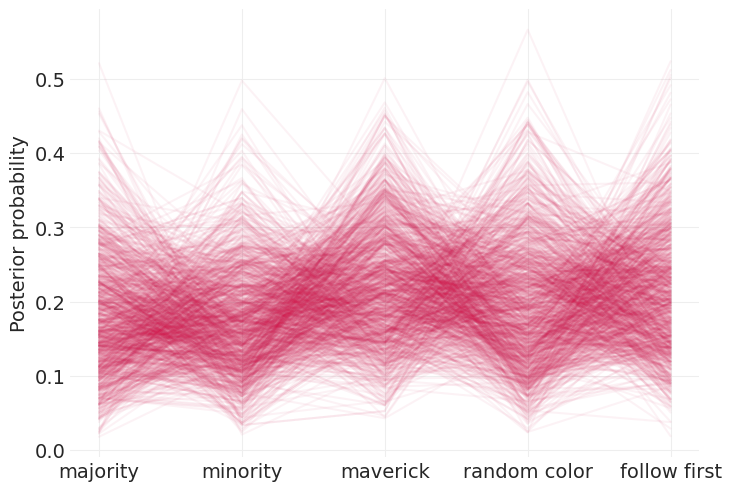

In [18]:
posterior_ps = child_strategy_inference.posterior["p"][0, :].values.T
xs = np.arange(5)
plt.plot(xs, posterior_ps, color="C0", alpha=0.05)
plt.xticks(xs, labels=STRATEGY)
plt.ylabel("Posterior probability");

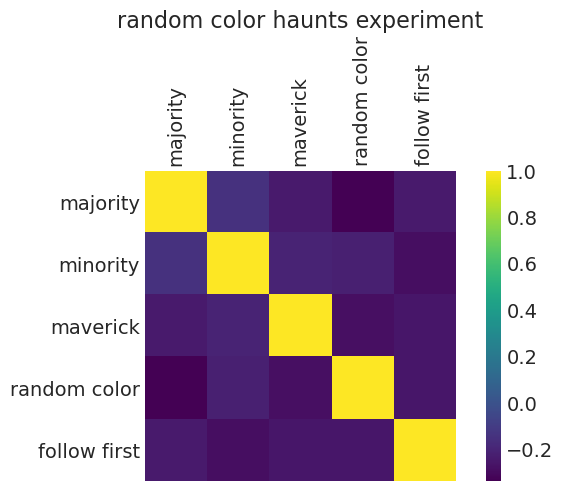

In [19]:
strategy_corrs = np.corrcoef(posterior_ps)

fig, ax = plt.subplots()
cax = ax.matshow(strategy_corrs)
ax.grid(None)
ax.set_xticks(np.arange(5))
ax.set_yticks(np.arange(5))
ax.set_xticklabels(STRATEGY, rotation=90)
ax.set_yticklabels(STRATEGY)
fig.colorbar(cax)
ax.set_title("random color haunts experiment");

## Review: State-based Models
- Want: unobserved latent states (e.g. strategy, knowledge state)
- Have: emmissions
  - can still elarn about state given emissions
- Typiclaly lots of uncertainty
  - the alternative is to run the incorrect analysis (e.g. running categorical regression)
- Large family of applications where there strategy or desired outcome in a strategy 
  - movement planning
  - learning
  - family planning

# Population Dynamics

- Latent states are time-varying
- Example: Ecological dynamics; the number of different species over time
- **Estimand**:
  - how do different species interact; how do interaction influence population dynamics
  - specifically **how do the populations of Lynx and Lepus (hares) interact over time?**
- 

In [20]:
POPULATION = utils.load_data("Lynx_Hare")
POPULATION

,Year,Lynx,Hare
0,1900,4.0,30.0
1,1901,6.1,47.2
2,1902,9.8,70.2
3,1903,35.2,77.4
4,1904,59.4,36.3
5,1905,41.7,20.6
6,1906,19.0,18.1
7,1907,13.0,21.4
8,1908,8.3,22.0
9,1909,9.1,25.4


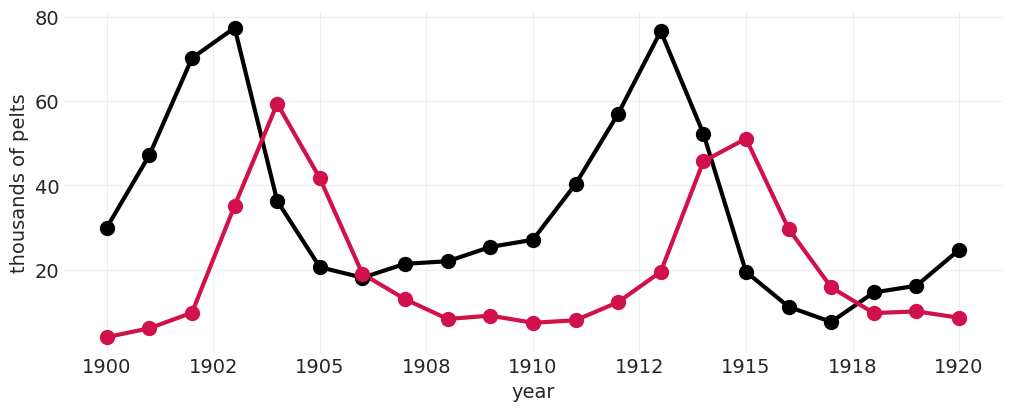

In [21]:
from matplotlib import ticker


def plot_population(data, ax=None):

    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))

    plt.scatter(data.Year, data.Hare, color="k", label="Lepus", zorder=100, s=100)
    utils.plot_line(data.Year, data.Hare, color="k", label="Lepus")

    plt.scatter(data.Year, data.Lynx, color="C0", label="Lynx", zorder=100, s=100)
    utils.plot_line(data.Year, data.Lynx, color="C0", label="Lynx")

    plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter("%.0f"))
    plt.xlabel("year")
    plt.ylabel("thousands of pelts")


plot_population(POPULATION)

## Lotka-Volterra Model

### Hare population model 🐰
$$
\begin{align*}
\frac{dH}{dt} &= H_t \times (\text{Hare birth rate}) - H_t \times (\text{Hare death rate}) \\
\frac{dH}{dt} &= H_t b_H - H_t (L_t m_H) & \text{birth rate independent of Lynx; death rate depends on \# of Lynx} \\
H_T &= H_1 + \int_1^T \frac{dH}{dt}dt &\text{Initial state, plus cumulative changes in population } \\
h_t &\sim \text{LogNormal}(p_H H_t, \sigma_H) &\text{Observation error distribution, } p_H \text{ is probability of getting trapped}
\end{align*}
$$


### Lynx population model 😸
$$
\begin{align*}
\frac{dL}{dt} &= L_t \times (\text{Lynx birth rate}) - L_t \times (\text{Lynx death rate}) \\
\frac{dL}{dt} &= L_t (H_t b_L) - L_t m_L &\text{birth rate depends on \# Hares; death rate independent of Hares}\\
L_T &= L_1 + \int_1^T \frac{dL}{dt}dt &\text{Initial state, plus cumulative changes in population }\\
l_t &\sim \text{LogNormal}(p_L L_t, \sigma_L), \sigma_L) &\text{Observation error distribution, } p_L \text{ is probability of getting trapped}
\end{align*}
$$

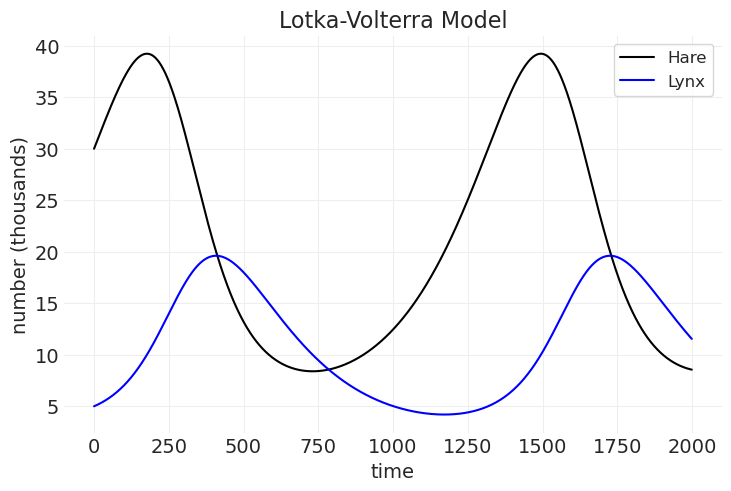

In [22]:
from numba import njit
from scipy.integrate import odeint


@njit
def lotka_volterra_diffeq(X, t, theta):
    # Unpack
    H, L = X
    bH, mH, bL, mL, _, _ = theta

    # Diff equations
    dH_dt = H * (bH - mH * L)
    dL_dt = L * (bL * H - mL)
    return [dH_dt, dL_dt]


def simulate_population_dynamics(
    initial_hares=30,
    initial_lynxes=5,
    birth_rate_hare=0.5,
    mortatily_rate_hare=0.05,
    birth_rate_lynx=0.025,
    mortality_rate_lynx=0.5,
    n_time_points=20,
    dt=1,
):
    time = np.arange(0, n_time_points, dt)
    theta = np.array(
        [
            birth_rate_hare,
            mortatily_rate_hare,
            birth_rate_lynx,
            mortality_rate_lynx,
            initial_hares,
            initial_lynxes,
        ]
    )
    HL = odeint(func=lotka_volterra_diffeq, y0=theta[-2:], t=time, args=(theta,))
    return HL[:, 0], HL[:, 1]


# Simulation with parameters shown in Figure 16.7 of the book (2nd edition)
hare_population, lynx_population = simulate_population_dynamics(
    initial_hares=30,
    initial_lynxes=5,
    birth_rate_hare=0.5,
    mortatily_rate_hare=0.05,
    birth_rate_lynx=0.025,
    mortality_rate_lynx=0.5,
    n_time_points=20,
    dt=0.01,
)
plt.plot(hare_population, color="k", label="Hare")
plt.plot(lynx_population, color="blue", label="Lynx")
plt.xlabel("time")
plt.ylabel("number (thousands)")
plt.legend()
plt.title("Lotka-Volterra Model");

## Statistical model

$$
\begin{align*}
H_0 &\sim \text{LogNormal}(\log 10, 1) &\text{prior for initial Hare population} \\
L_0 &\sim \text{LogNormal}(\log 10, 1) &\text{prior for initial Lynx population} \\
H_{T>0} &= H_0 + \int_1^T H_t(b_H - m_H L_t) dt &\text{temporal model for Hare population} \\
L_{T>0} &= L_0 + \int_1^T L_t(b_L H_t - m_L) dt &\text{temporal model for Lynx population} \\
\sigma_H &\sim \text{Exponential}(1) &\text{prior for Hare measurement variance} \\
\sigma_L &\sim \text{Exponential}(1) &\text{prior for Lynx measurement variance} \\
p_H &\sim \text{Beta}(40, 200) &\text{prior for Hare trap probabilty} \\
p_L &\sim \text{Beta}(40, 200) &\text{prior for Lynx trap probabilty} \\
b_H &\sim \text{HalfNormal}(1, 0.5) &\text{prior for Hare birth rate} \\
b_L &\sim \text{HalfNormal}(0.05, 0.05) &\text{prior for Lynx birth rate} \\
m_H &\sim \text{HalfNormal}(0.05, 0.05) &\text{prior for Hare mortality rate} \\
m_L &\sim \text{HalfNormal}(1, 0.5) &\text{prior for Lynx mortality rate} \\
\end{align*}
$$

### Prior predictive simulation

{'initial_hares_population': 62.46508314413322,
 'initial_lynx_population': 3.73218341358194,
 'p_trapped_hare': 0.18755284355997892,
 'p_trapped_lynx': 0.16310620806753454,
 'initial_hares': 11.715503966892694,
 'initial_lynxes': 0.6087422844018971,
 'birth_rate_hare': 0.5219090844879641,
 'mortality_rate_hare': 0.11569323766813411,
 'birth_rate_lynx': 0.07386090151797514,
 'mortality_rate_lynx': 0.9423111902497923,
 'hare_population': array([19.63817095, 29.19826078, 28.23651683, 50.71810838, 19.84793473,
         7.47923655,  4.24935002,  5.73155482,  6.39410051,  7.5552296 ,
        15.60151539, 28.22202333, 31.82844508, 39.9041958 , 31.36096064,
        13.88083494,  7.12609809,  5.41608361,  7.59162182, 10.5313164 ]),
 'lynx_population': array([ 0.83884324,  0.77317152,  2.46052459,  9.07240807, 20.22343338,
        14.06319061,  8.45831069,  4.3774741 ,  1.95684229,  1.155288  ,
         0.928704  ,  1.18563233,  1.71134393,  4.58554862, 16.26497351,
        19.61763805,  9.0946

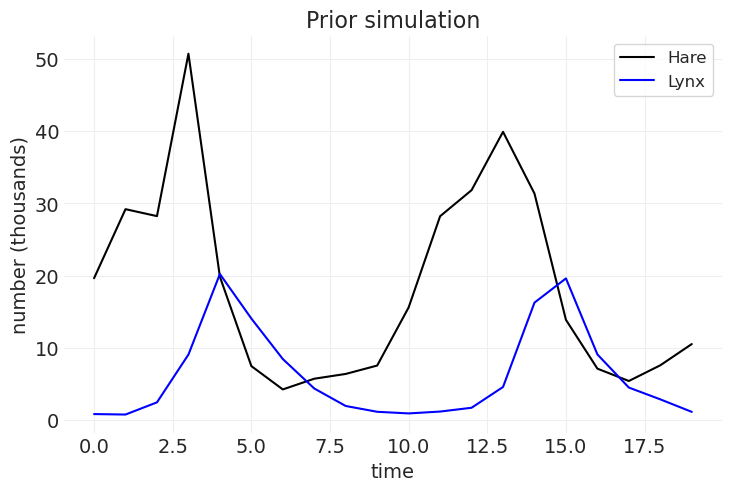

In [23]:
def sample_prior(random_seed=None):
    if random_seed is not None:
        np.random.seed(random_seed)

    # Initial population
    population_prior = stats.lognorm(np.log(10), 1)
    initial_hares_population = population_prior.rvs()
    initial_lynx_population = population_prior.rvs()

    # Observation model, probability of getting trapped
    trapped_prior = stats.beta(40, 200)
    p_trapped_hare = trapped_prior.rvs()
    p_trapped_lynx = trapped_prior.rvs()

    initial_hares = initial_hares_population * p_trapped_hare
    initial_lynxes = initial_lynx_population * p_trapped_lynx

    # Birth/mortality rates
    birth_rate_hare = stats.halfnorm(0.5, 0.5).rvs()
    birth_rate_lynx = stats.halfnorm(0.05, 0.05).rvs()

    mortality_rate_hare = stats.halfnorm(0.05, 0.05).rvs()
    mortality_rate_lynx = stats.halfnorm(0.5, 0.5).rvs()

    hare_population, lynx_population = simulate_population_dynamics(
        initial_hares,
        initial_lynxes,
        birth_rate_hare,
        mortality_rate_hare,
        birth_rate_lynx,
        mortality_rate_lynx,
        n_time_points=20,
        dt=1,
    )

    # Multiplicative noise
    hare_population *= 1 + np.random.rand(len(hare_population))
    lynx_population *= 1 + np.random.rand(len(lynx_population))

    plt.plot(hare_population, color="k", label="Hare")
    plt.plot(lynx_population, color="blue", label="Lynx")
    plt.xlabel("time")
    plt.ylabel("number (thousands)")
    plt.title("Prior simulation")
    plt.legend()

    return {
        "initial_hares_population": initial_hares_population,
        "initial_lynx_population": initial_lynx_population,
        "p_trapped_hare": p_trapped_hare,
        "p_trapped_lynx": p_trapped_lynx,
        "initial_hares": initial_hares,
        "initial_lynxes": initial_lynxes,
        "birth_rate_hare": birth_rate_hare,
        "mortality_rate_hare": mortality_rate_hare,
        "birth_rate_lynx": birth_rate_lynx,
        "mortality_rate_lynx": mortality_rate_lynx,
        "hare_population": hare_population,
        "lynx_population": lynx_population,
    }


prior_samples = sample_prior(random_seed=3)
SIMULATED_POPULATION = pd.DataFrame(
    {
        "Year": np.arange(1900, 1900 + len(prior_samples["hare_population"])),
        "Hare": prior_samples["hare_population"],
        "Lynx": prior_samples["lynx_population"],
    }
)
prior_samples

## Implement the statistical model

##### PyMC implementation details

PyMC has a built-in ODE solver, but the docs for that solver warn that it's pretty slow, and recommends that we use [Sunode ODE Solver](https://github.com/pymc-devs/sunode). AFAICT, at this point in time, the sunode solver isn't available for Mac M1 (i.e. it's not available on `conda-forge`, and installing from source is a bit of a mess on ARM64 chipset).

Indeed, I was finding the built-in ODE solver in PyMC (`pm.ode.DifferentialEquation`) prohibitive for building and debugging models (it was taking over an hour per model to sample; quite difficult to iterate at that pace). As an alternative approach, I'm using the implementation outlined in Lotke-Volterra examples in the PyMC docs. The approach is to wrap scipy's `odeint` function using Pytensor's `as_op` decorator so that variable input/output types are available via PyMC. This allows us to to use non-gradient based samplers (e.g. Slice sampler), which are a lot more forgiving to exotic models like ones that embed ODE integration.

⚠️ These models are super-sensitive to starting conditions, and I wasn't able to get the models to converge using the priors suggested in lecture. Instead, we perform an initial least-squares fit to the data, and inform our priors using the resulting least squares parameter estimates.

In [24]:
# Plotting helpers


def plot_data(data):
    utils.plot_scatter(data.Year, data.Hare, color="k", zorder=100, alpha=1)
    utils.plot_scatter(data.Year, data.Lynx, color="blue", zorder=100, alpha=1)


def plot_model_trace(inference_df, row_idx, lw=1, alpha=0.2, label=False):

    cols = ["bH", "mH", "bL", "mL", "initial_H", "initial_L"]
    theta = inference_df.loc[row_idx, cols].values
    p_trapped = inference_df.loc[row_idx, ["p_trapped_H", "p_trapped_L"]].values

    time = np.arange(1900, 1921, 0.01)

    # Run dynamics with model params
    HL = odeint(func=lotka_volterra_diffeq, y0=theta[-2:], t=time, args=(theta,))

    label_H = "Hare" if label else None
    label_L = "Lynx" if label else None
    hare_pelts = HL[:, 0] * p_trapped[0]
    lynx_pelts = HL[:, 1] * p_trapped[1]
    utils.plot_line(xs=time, ys=hare_pelts, color="k", alpha=0.1, label=label_H)
    utils.plot_line(xs=time, ys=lynx_pelts, color="blue", alpha=0.1, label=label_L)


def plot_population_model_posterior(
    inference,
    n_samples=25,
    title=None,
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    inference_df = inference.posterior.sel(chain=0).to_dataframe()

    for row_idx in range(n_samples):
        label = row_idx == 0
        plot_model_trace(inference_df, row_idx, label=label)

    plt.legend()
    plt.title(title, fontsize=16)

In [25]:
import pytensor.tensor as pt

from pytensor.compile.ops import as_op
from scipy.optimize import least_squares


def fit_lotka_volterra_model(data, theta_0=None):
    # Data
    H = data.Hare.values.astype(float)
    L = data.Lynx.values.astype(float)
    TIMES = data.Year.astype(float)

    # Step 0, get informed priors using Least Squares
    def ode_model_residuals(theta):
        # Calculates residuals for Lotka-Volterra model, based on a given state of params
        return (
            data[["Hare", "Lynx"]]
            - odeint(func=lotka_volterra_diffeq, y0=theta[-2:], t=data.Year, args=(theta,))
        ).values.flatten()

    # Least squares solution using the scipy's solver
    theta_0 = np.array([0.5, 0.025, 0.025, 0.75, H[0], L[0]]) if theta_0 is None else theta_0
    lstsq_solution = least_squares(ode_model_residuals, x0=theta_0)

    # Pack solution into a dictionary for more-readable code
    lstsq = {}
    parameter_names = ["bH", "mH", "bL", "mL", "H0", "L0"]
    for k, v in zip(parameter_names, lstsq_solution.x):
        lstsq[k] = v
    print("Initial Least Square Param Estimates:\n", lstsq)

    # Decorate so that input and output have Pytensor types.
    # This allows `odeint` to be available to PyMC as a valid operation
    @as_op(itypes=[pt.dvector], otypes=[pt.dmatrix])
    def pytensor_lotka_volterra_diffeq(theta):
        return odeint(func=lotka_volterra_diffeq, y0=theta[-2:], t=TIMES, args=(theta,))

    with pm.Model() as model:

        # Initial population priors
        initial_H = pm.LogNormal("initial_H", np.log(10), 1, initval=lstsq["H0"])
        initial_L = pm.LogNormal("initial_L", np.log(10), 1, initval=lstsq["L0"])

        # Hare param priors
        bH = pm.TruncatedNormal("bH", mu=lstsq["bH"], sigma=0.1, lower=0.0, initval=lstsq["bH"])
        mH = pm.TruncatedNormal("mH", mu=lstsq["mH"], sigma=0.05, lower=0.0, initval=lstsq["mH"])

        # Lynx param priors
        bL = pm.TruncatedNormal("bL", mu=lstsq["bL"], sigma=0.05, lower=0.0, initval=lstsq["bL"])
        mL = pm.TruncatedNormal("mL", mu=lstsq["mL"], sigma=0.1, lower=0.0, initval=lstsq["mL"])

        # Run dynamical system with current params/initial pops
        ode_solution = pytensor_lotka_volterra_diffeq(
            pm.math.stack([bH, mH, bL, mL, initial_H, initial_L])
        )

        # Observation model, probability of being trapped
        p_trapped_H = pm.Beta("p_trapped_H", 40, 200)
        p_trapped_L = pm.Beta("p_trapped_L", 40, 200)

        # Measurement error variance
        sigma_H = pm.Exponential("sigma_H", 1)
        sigma_L = pm.Exponential("sigma_L", 1)

        # Hare likelihood
        population_H = ode_solution[:, 0]
        mu_H = pm.math.log(population_H * p_trapped_H)
        pm.LogNormal("H", mu=mu_H, sigma=sigma_H, observed=H)

        # Lynx likelihood
        population_L = ode_solution[:, 1]
        mu_L = pm.math.log(population_L * p_trapped_L)
        pm.LogNormal("L", mu=mu_L, sigma=sigma_L, observed=L)

        inference = pm.sample()

    return model, inference

### Fit model to simulated data

In [26]:
lv_model_simualted, lt_inference_simulated = fit_lotka_volterra_model(
    SIMULATED_POPULATION,
    theta_0=np.array(
        [
            prior_samples["birth_rate_hare"],
            prior_samples["mortality_rate_hare"],
            prior_samples["birth_rate_lynx"],
            prior_samples["mortality_rate_lynx"],
            prior_samples["initial_hares"],
            prior_samples["initial_lynxes"],
        ]
    ),
)

Initial Least Square Param Estimates:
 {'bH': 0.4206452785407346, 'mH': 0.07341907569799343, 'bL': 0.06444364541512093, 'mL': 1.1815068440602556, 'H0': 17.997517919089947, 'L0': 0.575807704356167}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [initial_H]
>>Slice: [initial_L]
>>Slice: [bH]
>>Slice: [mH]
>>Slice: [bL]
>>Slice: [mL]
>NUTS: [p_trapped_H, p_trapped_L, sigma_H, sigma_L]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


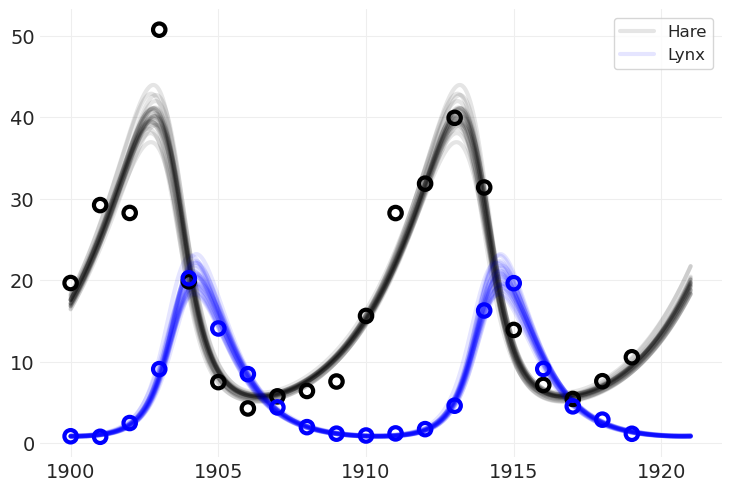

In [27]:
plot_population_model_posterior(lt_inference_simulated)
plot_data(SIMULATED_POPULATION)

### Fit model to real data data

In [28]:
lv_model, lt_inference = fit_lotka_volterra_model(POPULATION)

Initial Least Square Param Estimates:
 {'bH': 0.4812006467847881, 'mH': 0.024831840848356775, 'bL': 0.02753293803703795, 'mL': 0.926016346040929, 'H0': 34.914136989883445, 'L0': 3.8618647177263425}


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [initial_H]
>>Slice: [initial_L]
>>Slice: [bH]
>>Slice: [mH]
>>Slice: [bL]
>>Slice: [mL]
>NUTS: [p_trapped_H, p_trapped_L, sigma_H, sigma_L]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


### Plot the posterior
Note that we plot the posterior over a finer grid than the data itself. This can be done using the posterior params, and running the ODE at a higher resolution than the data

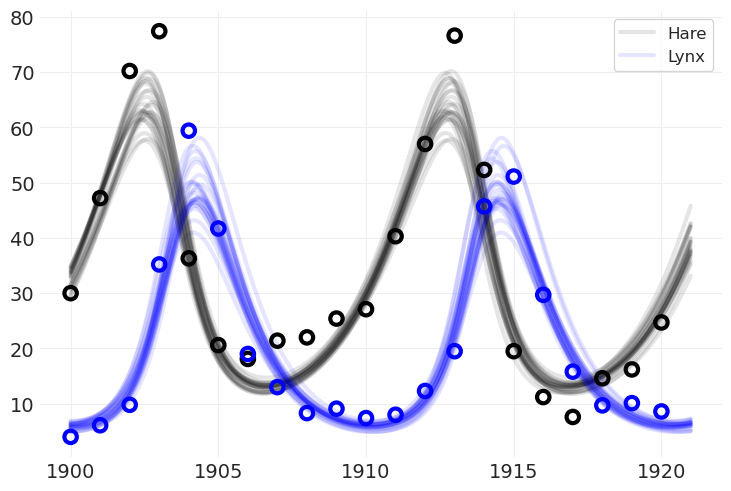

In [29]:
plot_population_model_posterior(lt_inference)
plot_data(POPULATION)

## Review: Population Dynamics
- Ecologies are much more complex than this simple model
  - e.g. many other animals prey on hares
- Without causal structure/model; there is little hope understanding policy intervention

## Authors
* Ported to PyMC by Dustin Stansbury (2024)
* Based on Statistical Rethinking (2023) lectures by Richard McElreath

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor,xarray

Last updated: Tue Dec 17 2024

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

pytensor: 2.26.4
xarray  : 2024.7.0

pandas     : 2.2.2
numpy      : 1.26.4
arviz      : 0.19.0
matplotlib : 3.9.2
xarray     : 2024.7.0
scipy      : 1.14.1
numba      : 0.60.0
statsmodels: 0.14.2
pytensor   : 2.26.4
pymc       : 5.19.1

Watermark: 2.5.0



:::{include} ../page_footer.md
:::